## Prize Collecting Steiner Tree (PCST) with limited number of hops  

### Problem definition

>**Given**
>A symmetric graph $G=(V,E)$ and a cost $c_e > 0$ for each edge in $E$.
>A root node $\{0\}$.
>A revenue $p_j > 0$ for each node $j \in V \setminus \{0\}$.
>
>**Find**
>A subtree 𝑇 rooted in {0} that maximizes the sum of the revenues of the nodes in 𝑇 minus the sum of the cost of the edges in 𝑇 such that the distance between {0} and any node in 𝑇 does not exceed H.

### Directed formulation

Consider the bidirected graph $B=(V,A)$ that is obtained from $G$ by replacing each edge $e = \{i, j\}$ in $E$ with two directed arcs $(i, j)$ and
$(j, i)$ (with corresponding weights $c_{ij} = c_{ji} = c_e )$ and a cost $c_e > 0$ for each edge in $E$



> **PCST-H** is equivalent to find an optimal arborescence in B rooted in $\{0\}$


#### Variables
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the arborescence} \\
0 \text{ otherwise}
\end{cases}
$$

$$
y_j = \begin{cases} 1 \text{ if node j is in the arborescence}\\
0 \text{ otherwise}
\end{cases}
$$

$$ 
u_j = \{\text{number of arcs in the dipath (if any) induced by $x$ from \{0\} to $j$}\}
$$

#### MTZ formulation

$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} - \sum_{j \in V \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V \setminus \{0\}\\
(h+1)x_{ij} + u_i - u_j &\le h \;\; \forall (i,j) \in A \\
y_i \le u_i &\le h y_i \;\; \forall i \in V\setminus \{0\}\\ 
x_{jk} &\le y_j \;\; \forall k \in \delta^+(j), \;\; \forall j \in V \setminus\{0\}\\
0 \le u_j & \le n \;\; \forall j \in V \\ 
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V
\end{align}
$$


In [66]:
import networkx as nx
import gurobi as gb
import os
import matplotlib.pyplot as plt

#
# Drawing 
# functions
#

def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        

    
    #edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v].x > 0.1]

    
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    figsize = 30,60
    scale = 40
  

In [67]:
# 
# Read the graph in the graphML format
#

args.filename = 'pcst.gml'

args.figsize = (15,25)



basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

D = G.to_directed()

root = 1



G has 30 nodes and 435 edges


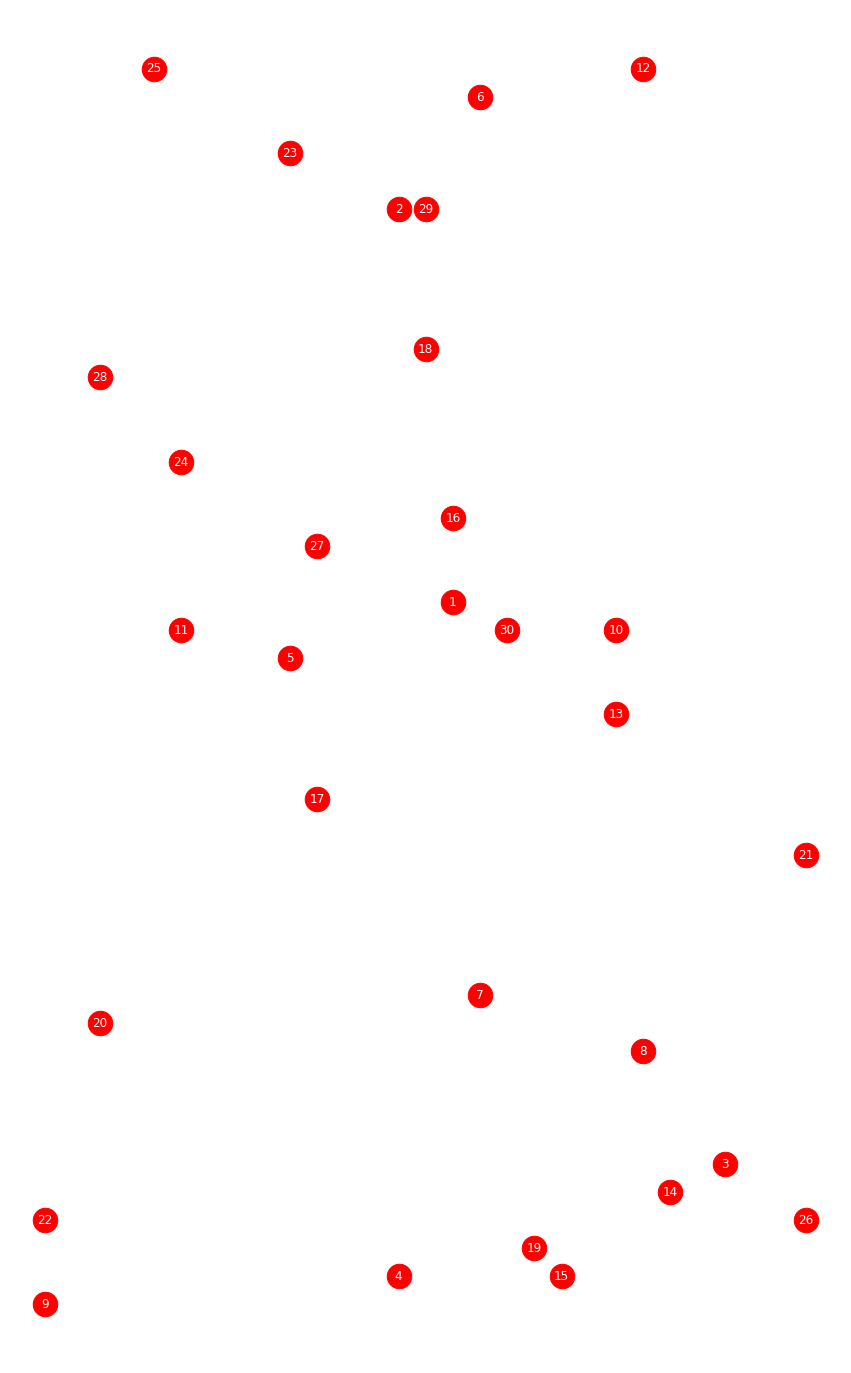

In [68]:
root = 1
pos = {i:(G.nodes[i]['x'] * args.scale,G.nodes[i]['y'] * args.scale) for i in G.nodes()}
DrawInitG(G)


In [69]:
pcst = gb.Model()


In [70]:
# H represents the maximum number of hops

H = 3



#
# Variables definition
#


x = pcst.addVars(D.edges(), vtype=gb.GRB.BINARY,\
                 obj = [- D[i][j]['cost'] for (i,j) in D.edges()], \
                 name = 'x')

y = pcst.addVars (G.nodes(), vtype = gb.GRB.BINARY,\
                  obj = [G.nodes[i]['revenue'] for i in G.nodes()],\
                 name = 'y')

u = pcst.addVars (G.nodes(), vtype = gb.GRB.CONTINUOUS, \
                  lb = 0.0, ub = G.number_of_nodes(),\
                 name = 'u')


pcst.ModelSense = gb.GRB.MAXIMIZE

In [71]:
#
# Root is in the solution
#

pcst.addConstr(y[root] == 1, name = 'Fix')

pcst.update()

In [72]:
#
# Each node has exactly one incoming arc
#

pcst.addConstrs((x.sum('*',j) == y[j] for j in G.nodes() if j != root), name='Node')

pcst.update()

In [73]:
#
# Precedence constraints (MTZ constraints)
#

pcst.addConstrs(((H + 1) * x[i,j] \
                + u[i] - u[j] <= H for i,j in D.edges()),\
                name = 'MTZ')

pcst.update()

In [74]:

#
# Connectivity constraints
#

pcst.addConstrs((x[j,k] <= y[j] for j in G.nodes() \
                 if j != root for k in D.neighbors(j)), name = 'Connect')

pcst.update() 


$$u_i \ge y_i, \;\; \forall i \in V\setminus\{0\}$$  

In [75]:
pcst.addConstrs ((u[i] >= y[i] for i in G.nodes() \
                  if i != root), name='VLB')

pcst.update()

$$u_i \le H y_i, \;\; \forall i \in V\setminus\{0\}$$  

In [76]:
pcst.addConstrs ((u[i] <= H * y[i] for i in G.nodes() \
                  if i != root), name='VUB')

pcst.update()

In [77]:
pcst.write('pcst-hop.lp')

In [78]:
pcst.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1799 rows, 930 columns and 5279 nonzeros
Model fingerprint: 0xbe12b7a3
Variable types: 30 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 822.0000000
Presolve removed 59 rows and 31 columns
Presolve time: 0.03s
Presolved: 1740 rows, 899 columns, 5104 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)

Root relaxation: objective 5.557000e+03, 79 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5557.00000    0   22  822.00000 5557.00000   576%     -    0s
H    0     0                    1512.0000000 5557

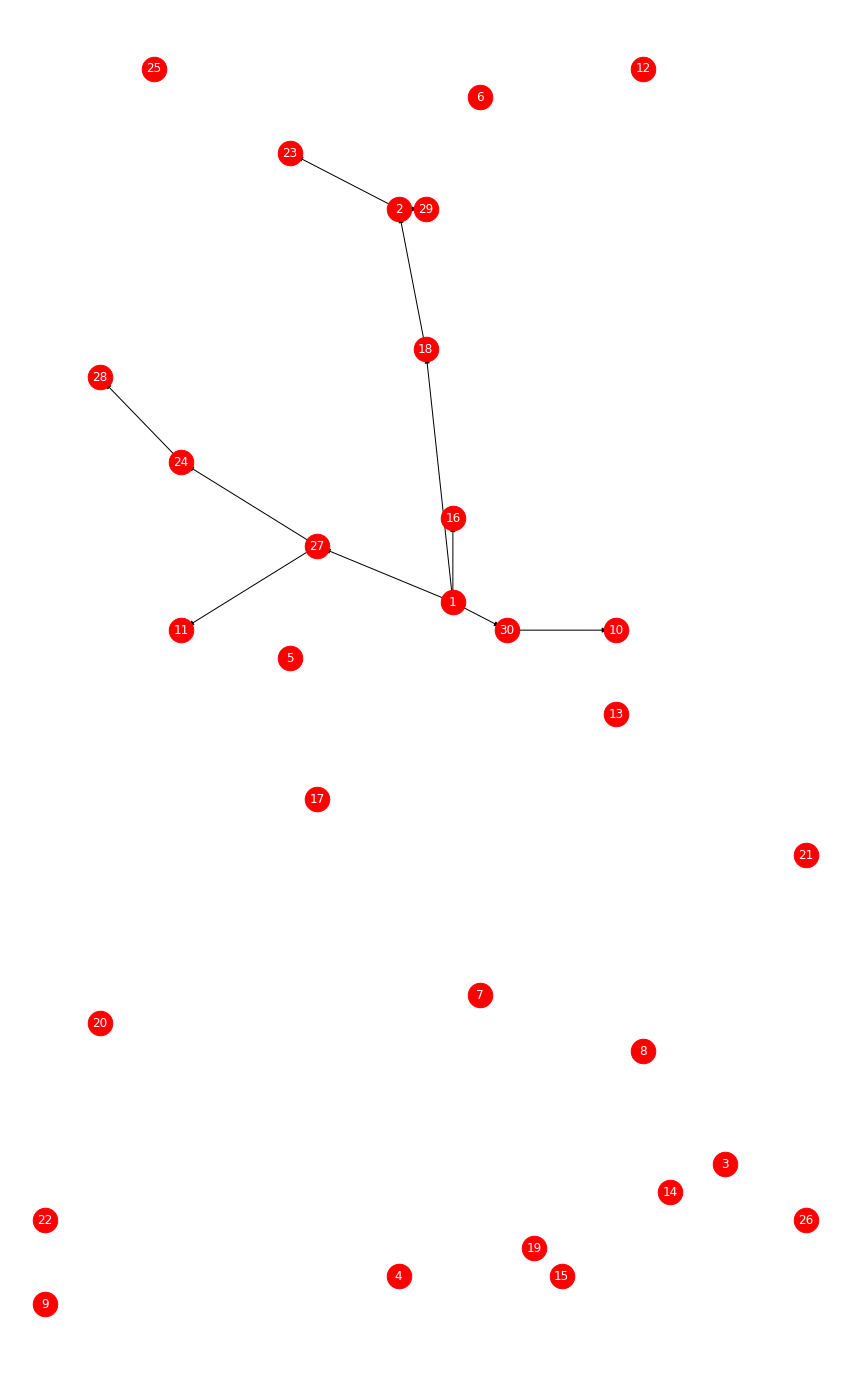

In [79]:
DrawSol(D, x)




In [80]:
u

{1: <gurobi.Var u[1] (value 0.0)>,
 2: <gurobi.Var u[2] (value 2.0)>,
 3: <gurobi.Var u[3] (value 0.0)>,
 4: <gurobi.Var u[4] (value 0.0)>,
 5: <gurobi.Var u[5] (value 0.0)>,
 6: <gurobi.Var u[6] (value 2.3314683517128287e-15)>,
 7: <gurobi.Var u[7] (value 0.0)>,
 8: <gurobi.Var u[8] (value 0.0)>,
 9: <gurobi.Var u[9] (value 0.0)>,
 10: <gurobi.Var u[10] (value 2.0)>,
 11: <gurobi.Var u[11] (value 3.0)>,
 12: <gurobi.Var u[12] (value 0.0)>,
 13: <gurobi.Var u[13] (value 0.0)>,
 14: <gurobi.Var u[14] (value 0.0)>,
 15: <gurobi.Var u[15] (value 0.0)>,
 16: <gurobi.Var u[16] (value 1.0)>,
 17: <gurobi.Var u[17] (value 0.0)>,
 18: <gurobi.Var u[18] (value 1.0000000000000018)>,
 19: <gurobi.Var u[19] (value 0.0)>,
 20: <gurobi.Var u[20] (value 0.0)>,
 21: <gurobi.Var u[21] (value 0.0)>,
 22: <gurobi.Var u[22] (value 0.0)>,
 23: <gurobi.Var u[23] (value 3.0)>,
 24: <gurobi.Var u[24] (value 2.0)>,
 25: <gurobi.Var u[25] (value 0.0)>,
 26: <gurobi.Var u[26] (value 0.0)>,
 27: <gurobi.Var u[27]

In [81]:
totalcost = 0

for i,j in D.edges():
        if x[i,j].x > 0.9:
                totalcost += D[i][j]['cost']

print ("Total cost", totalcost)

Total cost 5012


In [82]:
costs ={(i,j): D[i][j]['cost'] for (i,j) in D.edges()}

#costs

In [83]:
#x.prod(costs)

In [84]:
budget = 4000

pcst.addConstr(x.prod(costs) <= budget, 'Budget')

<gurobi.Constr *Awaiting Model Update*>

In [85]:
pcst.update()

pcst.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1800 rows, 930 columns and 6149 nonzeros
Model fingerprint: 0x54e1937f
Variable types: 30 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 4e+03]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint Budget by 1012.000000000

Found heuristic solution: objective 822.0000000
Presolve removed 552 rows and 172 columns
Presolve time: 0.17s
Presolved: 1248 rows, 758 columns, 7190 nonzeros
Variable types: 29 continuous, 729 integer (729 binary)

Root relaxation: objective 5.180727e+03, 85 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Bes

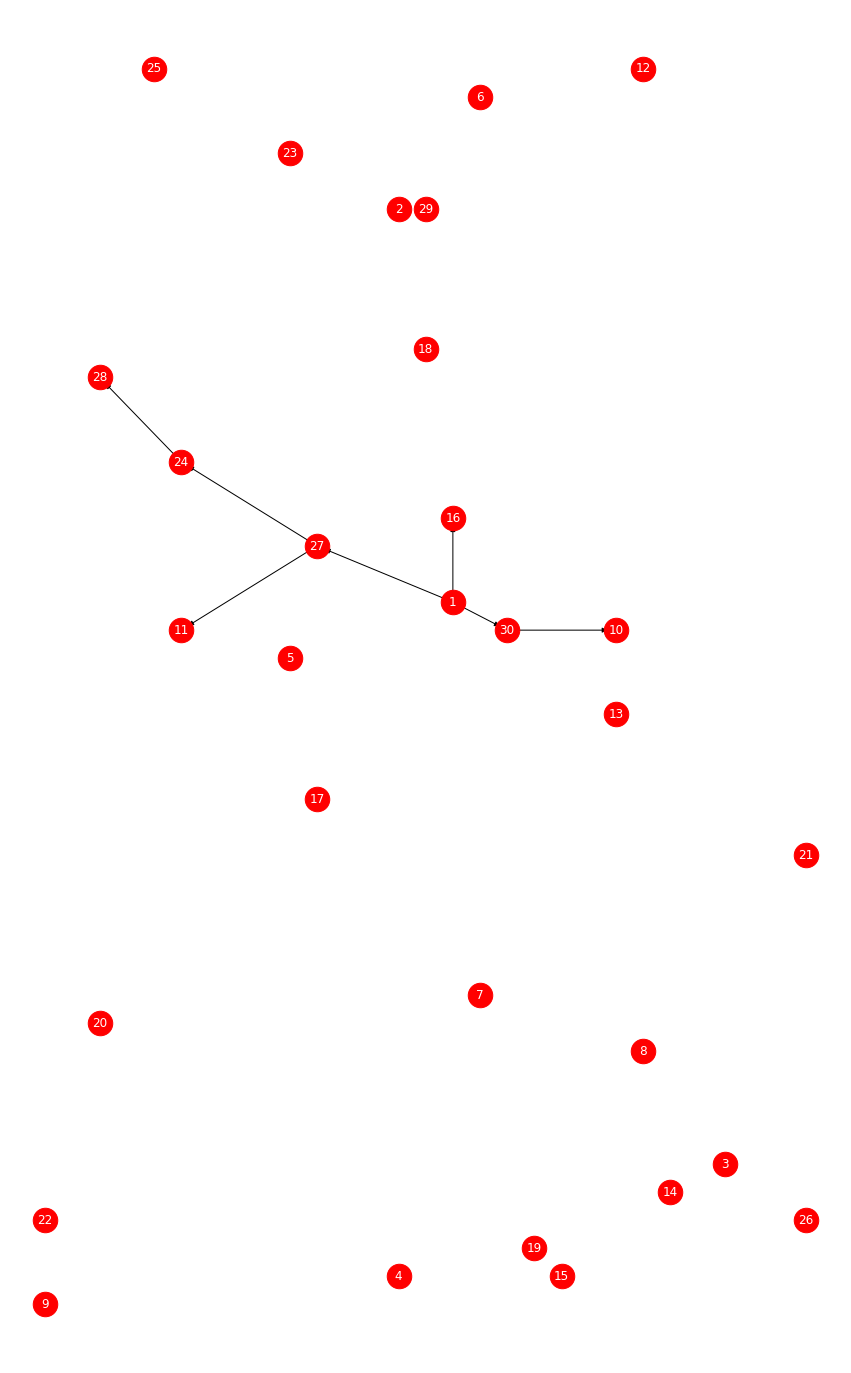

In [65]:
DrawSol(D, x)


